In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
import uuid


In [ ]:
df = pd.read_csv("/content/sample_data/who_dataset_fixed.csv")

feature_names = [
    'Infant_deaths', 'Under_five_deaths', 'Adult_mortality',
    'Alcohol_consumption', 'Hepatitis_B', 'Measles',
    'BMI', 'Diphtheria', 'Incidents_HIV', 'GDP_per_capita',
    'Population_mln', 'Thinness_ten_nineteen_years',
    'Thinness_five_nine_years', 'Schooling'
]
target = 'Life_expectancy'

X = df[feature_names].copy()
y = df[target].copy()
countries = df["Country"].astype("category")
country_codes = countries.cat.codes.values
country_names = countries.cat.categories

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_centered = y - y.mean()

In [ ]:
with pm.Model() as hierarchical_model:
    X_data = pm.MutableData("X", X_scaled)
    y_data = pm.MutableData("y", y_centered)
    country_idx = pm.MutableData("country_idx", country_codes)

    alpha_mu = pm.Normal("alpha_mu", mu=0, sigma=10)
    alpha_sigma = pm.HalfNormal("alpha_sigma", sigma=5)
    alpha_country = pm.Normal("alpha_country", mu=alpha_mu, sigma=alpha_sigma, shape=len(country_names))

    betas = [pm.Normal(name, mu=0, sigma=1) for name in feature_names]
    beta_stack = pm.math.stack(betas)

    mu = alpha_country[country_idx] + pm.math.dot(X_data, beta_stack)

    sigma = pm.HalfNormal("sigma", sigma=10)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data)

    trace = pm.sample(2000, tune=1000, target_accept=0.8, return_inferencedata=True)

/usr/local/lib/python3.11/dist-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
pd.set_option("display.max_rows", 300)
summary = az.summary(trace, round_to=4)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Adult_mortality,-5.1626,0.0799,-5.3071,-5.0058,0.0032,0.0016,619.5755,1290.6965,1.0011
Alcohol_consumption,-0.2127,0.0502,-0.3034,-0.1181,0.0028,0.0012,330.9892,794.7581,1.0005
BMI,0.9066,0.0885,0.7393,1.0734,0.0068,0.0034,171.7683,329.2078,1.0301
Diphtheria,0.1080,0.0289,0.0501,0.1586,0.0006,0.0004,2314.0814,2575.6756,0.9997
GDP_per_capita,1.0277,0.0860,0.8672,1.1884,0.0054,0.0031,253.7109,504.5213,1.0081
Hepatitis_B,0.0652,0.0231,0.0249,0.1101,0.0005,0.0003,1764.8417,2287.6358,1.0003
Incidents_HIV,0.3701,0.0620,0.2541,0.4882,0.0025,0.0013,631.1493,1096.0399,1.0024
Infant_deaths,-0.6968,0.1986,-1.0698,-0.3182,0.0099,0.0042,403.4408,968.4766,1.0014
Measles,0.0909,0.0274,0.0385,0.1392,0.0008,0.0004,1067.6365,1912.5606,1.0038
Population_mln,0.2520,0.1143,0.0416,0.4657,0.0052,0.0025,478.0568,1045.7471,1.0090


In [ ]:
with hierarchical_model:
    posterior_pred = pm.sample_posterior_predictive(trace, var_names=["y_obs"])

y_pred_samples = posterior_pred.posterior_predictive["y_obs"].values + y.mean()
if y_pred_samples.ndim == 3:
    y_pred_samples = y_pred_samples.reshape(-1, y_pred_samples.shape[-1])
y_pred_mean = y_pred_samples.mean(axis=0)
lower = np.percentile(y_pred_samples, 3, axis=0)
upper = np.percentile(y_pred_samples, 97, axis=0)

Output()

In [ ]:
df_scaled = pd.DataFrame(X_scaled, columns=feature_names)
df_scaled["Life_expectancy"] = y
df_scaled["Country"] = countries

formula = "Life_expectancy ~ " + " + ".join(feature_names)
mixed_model = smf.mixedlm(formula, df_scaled, groups=df_scaled["Country"])
mixed_result = mixed_model.fit()

y_pred_mixed = mixed_result.predict(df_scaled)

rmse_bayesian = np.sqrt(mean_squared_error(y, y_pred_mean))
mae_bayesian = mean_absolute_error(y, y_pred_mean)
rmse_mixed = np.sqrt(mean_squared_error(y, y_pred_mixed))
mae_mixed = mean_absolute_error(y, y_pred_mixed)

print("\nModel Comparison:")
print(f"Bayesian Hierarchical RMSE: {rmse_bayesian:.3f}, MAE: {mae_bayesian:.3f}")
print(f"Frequentist Mixed Effects RMSE: {rmse_mixed:.3f}, MAE: {mae_mixed:.3f}")


Model Comparison:
Bayesian Hierarchical RMSE: 0.509, MAE: 0.351
Frequentist Mixed Effects RMSE: 1.858, MAE: 1.419


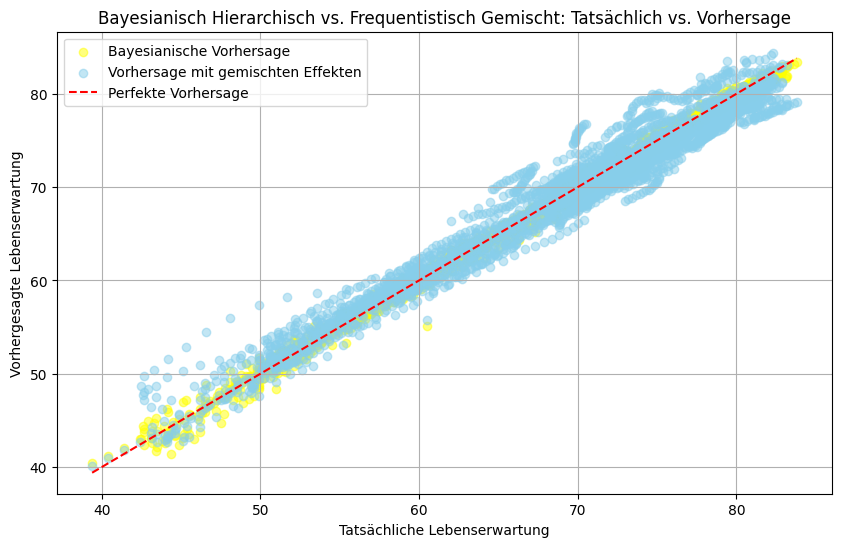

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_mean, alpha=0.5, color='yellow', label='Bayesianische Vorhersage')
plt.scatter(y, y_pred_mixed, alpha=0.5, color='skyblue', label='Vorhersage mit gemischten Effekten')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfekte Vorhersage")
plt.xlabel("Tatsächliche Lebenserwartung")
plt.ylabel("Vorhergesagte Lebenserwartung")
plt.title("Bayesianisch Hierarchisch vs. Frequentistisch Gemischt: Tatsächlich vs. Vorhersage")
plt.legend()
plt.grid(True)
plt.savefig('bayesian_vs_mixed.png')
plt.show()


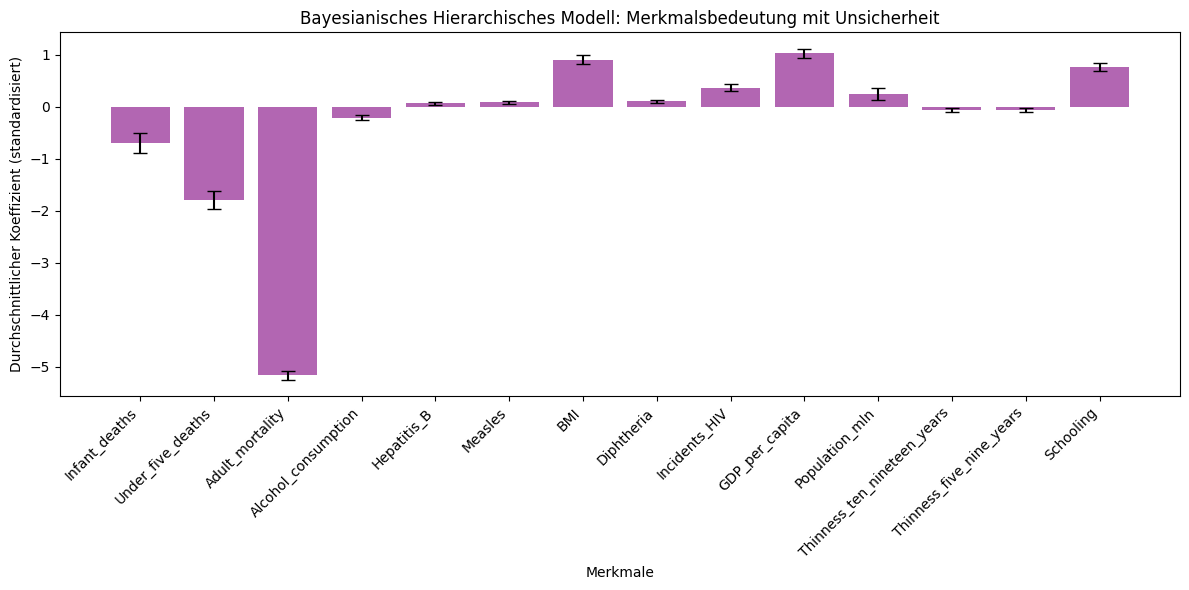

In [ ]:
beta_means = summary.loc[feature_names, 'mean']
beta_sd = summary.loc[feature_names, 'sd']
plt.figure(figsize=(12, 6))
plt.bar(feature_names, beta_means, yerr=beta_sd, capsize=5, color='purple', alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Merkmale")
plt.ylabel("Durchschnittlicher Koeffizient (standardisiert)")
plt.title("Bayesianisches Hierarchisches Modell: Merkmalsbedeutung mit Unsicherheit")
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()


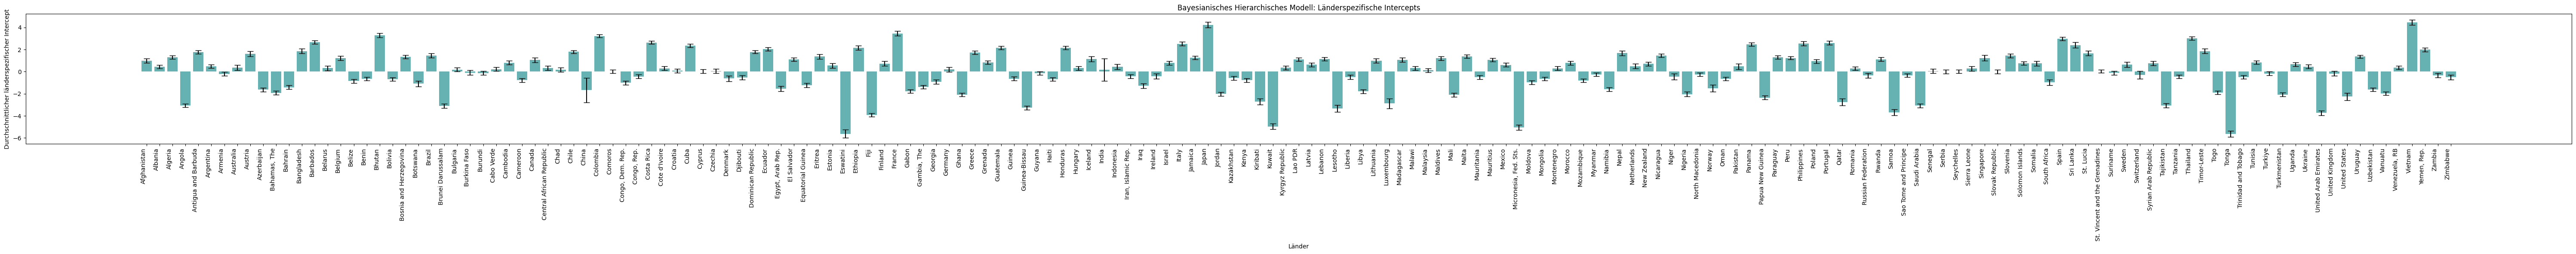

In [ ]:
alpha_country_means = summary.loc[[f"alpha_country[{i}]" for i in range(len(country_names))], 'mean']
alpha_country_sd = summary.loc[[f"alpha_country[{i}]" for i in range(len(country_names))], 'sd']
plt.figure(figsize=(60, 6))
plt.bar(country_names, alpha_country_means, yerr=alpha_country_sd, capsize=5, color='teal', alpha=0.6)
plt.xticks(rotation=90, ha='right')
plt.xlabel("Länder")
plt.ylabel("Durchschnittlicher länderspezifischer Intercept")
plt.title("Bayesianisches Hierarchisches Modell: Länderspezifische Intercepts")
plt.tight_layout()
plt.savefig('country_intercepts.png')
plt.show()


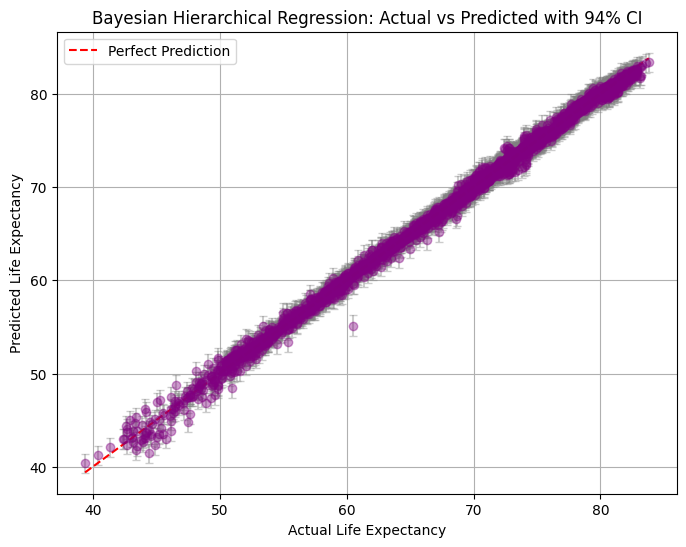

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(y, y_pred_mean,
             yerr=[y_pred_mean - lower, upper - y_pred_mean],
             fmt='o', alpha=0.4, color='purple', ecolor='gray', capsize=3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Bayesian Hierarchical Regression: Actual vs Predicted with 94% CI")
plt.legend()
plt.grid(True)
plt.savefig('credible_intervals.png')
plt.show()

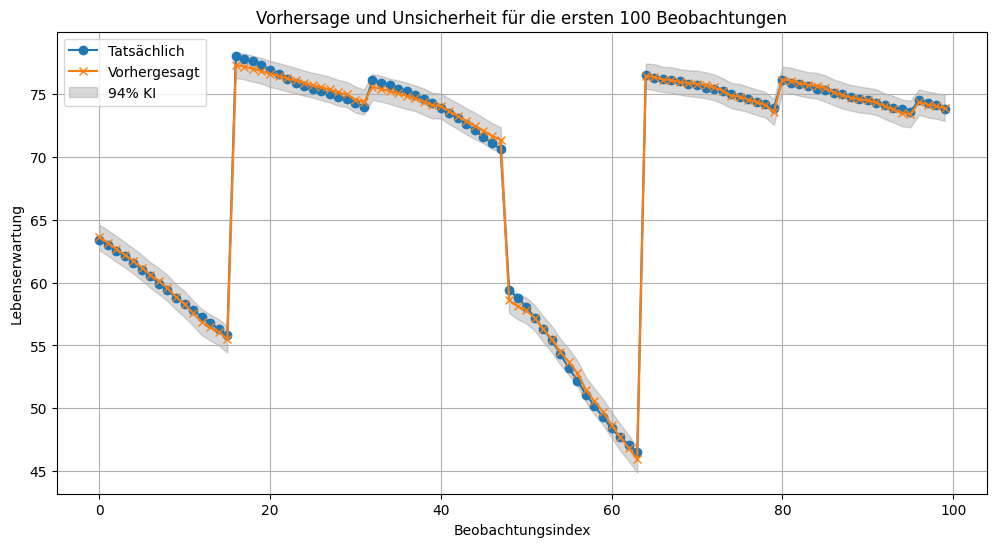

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y[:100], label="Tatsächlich", marker="o")
plt.plot(y_pred_mean[:100], label="Vorhergesagt", marker="x")
plt.fill_between(np.arange(100), lower[:100], upper[:100], alpha=0.3, color="gray", label="94% KI")
plt.title("Vorhersage und Unsicherheit für die ersten 100 Beobachtungen")
plt.ylabel("Lebenserwartung")
plt.xlabel("Beobachtungsindex")
plt.legend()
plt.grid(True)
plt.savefig('first_100_predictions.png')
plt.show()

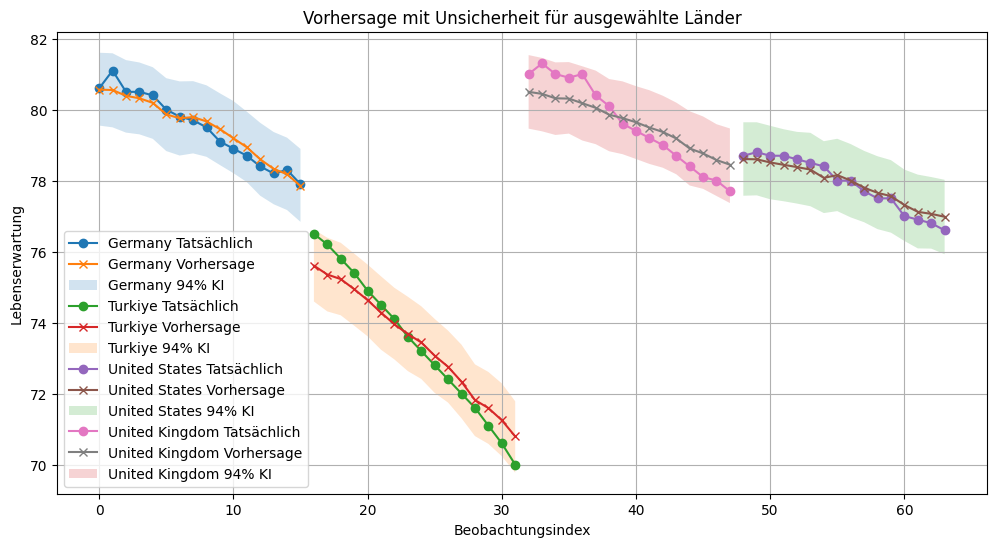

In [ ]:
# Vorhersage und Unsicherheit für ausgewählte Länder
countries_of_interest = ["Germany", "Turkiye", "United States", "United Kingdom"]
df_filtered = df[df["Country"].isin(countries_of_interest)].copy()
y_filtered = df_filtered["Life_expectancy"].values
original_indices = df_filtered.index
y_pred_mean_filtered = y_pred_mean[original_indices]
lower_filtered = lower[original_indices]
upper_filtered = upper[original_indices]
countries_filtered = df_filtered["Country"].values

plt.figure(figsize=(12, 6))
for country in countries_of_interest:
    indices = np.where(countries_filtered == country)[0]
    plt.plot(indices, y_filtered[indices], 'o-', label=f"{country} Tatsächlich")
    plt.plot(indices, y_pred_mean_filtered[indices], 'x-', label=f"{country} Vorhersage")
    plt.fill_between(indices, lower_filtered[indices], upper_filtered[indices], alpha=0.2, label=f"{country} 94% KI")
plt.title("Vorhersage mit Unsicherheit für ausgewählte Länder")
plt.xlabel("Beobachtungsindex")
plt.ylabel("Lebenserwartung")
plt.legend()
plt.grid(True)
plt.savefig('countries_prediction.png')
plt.show()


In [ ]:
germany_data = df[df["Country"] == "Germany"].copy()
germany_indices = germany_data.index
germany_years = germany_data["Year"].values
germany_actual = germany_data["Life_expectancy"].values

germany_pred_samples = y_pred_samples[:, germany_indices]
germany_pred_mean = y_pred_mean[germany_indices]
germany_pred_lower = lower[germany_indices]
germany_pred_upper = upper[germany_indices]

gdp_beta = summary.loc["GDP_per_capita", "mean"]
gdp_beta_sd = summary.loc["GDP_per_capita", "sd"]

gdp_idx = feature_names.index("GDP_per_capita")
gdp_original = germany_data["GDP_per_capita"].values
gdp_scaled = X_scaled[germany_indices, gdp_idx]

gdp_scaled_plus_1sd = gdp_scaled + 1.0
delta_gdp_1sd = gdp_scaled_plus_1sd - gdp_scaled
germany_pred_mean_1sd = germany_pred_mean + delta_gdp_1sd * gdp_beta
germany_pred_samples_1sd = germany_pred_samples + delta_gdp_1sd[None, :] * np.random.normal(gdp_beta, gdp_beta_sd, size=(germany_pred_samples.shape[0], 1))
germany_pred_lower_1sd = np.percentile(germany_pred_samples_1sd, 3, axis=0)
germany_pred_upper_1sd = np.percentile(germany_pred_samples_1sd, 97, axis=0)

gdp_original_plus_1000 = gdp_original + 1000
gdp_scaled_plus_1000 = scaler.transform(germany_data[feature_names].copy())
gdp_scaled_plus_1000[:, gdp_idx] = (gdp_original_plus_1000 - scaler.mean_[gdp_idx]) / scaler.scale_[gdp_idx]
gdp_scaled_plus_1000 = gdp_scaled_plus_1000[:, gdp_idx]
delta_gdp_1000 = gdp_scaled_plus_1000 - gdp_scaled
germany_pred_mean_1000 = germany_pred_mean + delta_gdp_1000 * gdp_beta
germany_pred_samples_1000 = germany_pred_samples + delta_gdp_1000[None, :] * np.random.normal(gdp_beta, gdp_beta_sd, size=(germany_pred_samples.shape[0], 1))
germany_pred_lower_1000 = np.percentile(germany_pred_samples_1000, 3, axis=0)
germany_pred_upper_1000 = np.percentile(germany_pred_samples_1000, 97, axis=0)


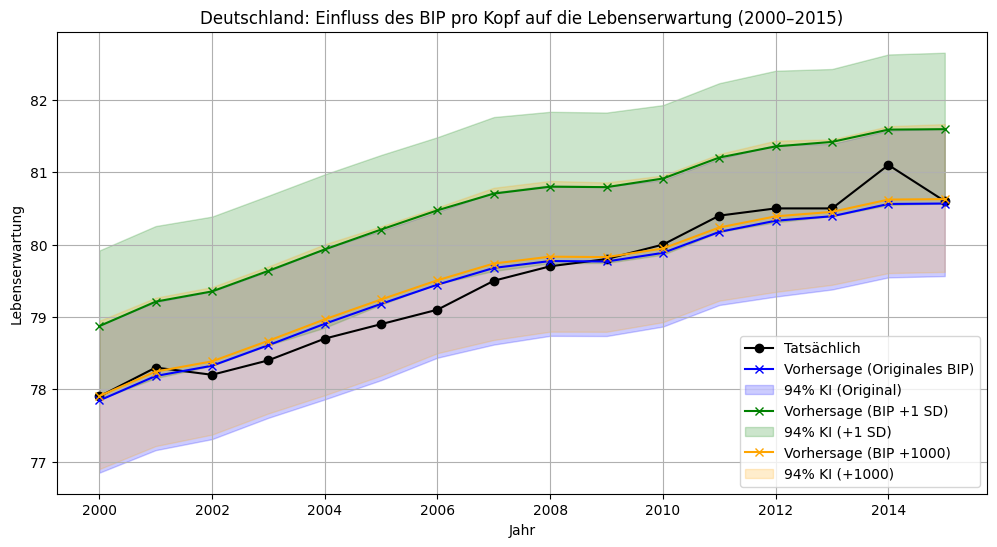

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(germany_years, germany_actual, 'o-', label="Tatsächlich", color='black')
plt.plot(germany_years, germany_pred_mean, 'x-', label="Vorhersage (Originales BIP)", color='blue')
plt.fill_between(germany_years, germany_pred_lower, germany_pred_upper, alpha=0.2, color='blue', label="94% KI (Original)")
plt.plot(germany_years, germany_pred_mean_1sd, 'x-', label="Vorhersage (BIP +1 SD)", color='green')
plt.fill_between(germany_years, germany_pred_lower_1sd, germany_pred_upper_1sd, alpha=0.2, color='green', label="94% KI (+1 SD)")
plt.plot(germany_years, germany_pred_mean_1000, 'x-', label="Vorhersage (BIP +1000)", color='orange')
plt.fill_between(germany_years, germany_pred_lower_1000, germany_pred_upper_1000, alpha=0.2, color='orange', label="94% KI (+1000)")
plt.xlabel("Jahr")
plt.ylabel("Lebenserwartung")
plt.title("Deutschland: Einfluss des BIP pro Kopf auf die Lebenserwartung (2000–2015)")
plt.legend()
plt.grid(True)
plt.savefig('germany_gdp_simulation.png')
plt.show()


In [ ]:
print("\nGermany GDP Simulation Results (2000-2015):")
for year, actual, orig_mean, orig_lower, orig_upper, mean_1sd, lower_1sd, upper_1sd, mean_1000, lower_1000, upper_1000 in zip(
    germany_years, germany_actual, germany_pred_mean, germany_pred_lower, germany_pred_upper,
    germany_pred_mean_1sd, germany_pred_lower_1sd, germany_pred_upper_1sd,
    germany_pred_mean_1000, germany_pred_lower_1000, germany_pred_upper_1000
):
    print(f"\nYear: {year}")
    print(f"Actual Life Expectancy: {actual:.2f}")
    print(f"Predicted (Original GDP): {orig_mean:.2f} (94% CI: [{orig_lower:.2f}, {orig_upper:.2f}])")
    print(f"Predicted (GDP +1 SD): {mean_1sd:.2f} (94% CI: [{lower_1sd:.2f}, {upper_1sd:.2f}])")
    print(f"Predicted (GDP +1000): {mean_1000:.2f} (94% CI: [{lower_1000:.2f}, {upper_1000:.2f}])")


Germany GDP Simulation Results (2000-2015):

Year: 2015
Actual Life Expectancy: 80.60
Predicted (Original GDP): 80.57 (94% CI: [79.56, 81.60])
Predicted (GDP +1 SD): 81.59 (94% CI: [80.57, 82.65])
Predicted (GDP +1000): 80.63 (94% CI: [79.62, 81.67])

Year: 2014
Actual Life Expectancy: 81.10
Predicted (Original GDP): 80.56 (94% CI: [79.55, 81.58])
Predicted (GDP +1 SD): 81.59 (94% CI: [80.55, 82.63])
Predicted (GDP +1000): 80.62 (94% CI: [79.61, 81.64])

Year: 2013
Actual Life Expectancy: 80.50
Predicted (Original GDP): 80.39 (94% CI: [79.38, 81.39])
Predicted (GDP +1 SD): 81.42 (94% CI: [80.39, 82.43])
Predicted (GDP +1000): 80.45 (94% CI: [79.44, 81.45])

Year: 2012
Actual Life Expectancy: 80.50
Predicted (Original GDP): 80.33 (94% CI: [79.28, 81.38])
Predicted (GDP +1 SD): 81.36 (94% CI: [80.31, 82.40])
Predicted (GDP +1000): 80.39 (94% CI: [79.35, 81.44])

Year: 2011
Actual Life Expectancy: 80.40
Predicted (Original GDP): 80.18 (94% CI: [79.16, 81.19])
Predicted (GDP +1 SD): 81.20

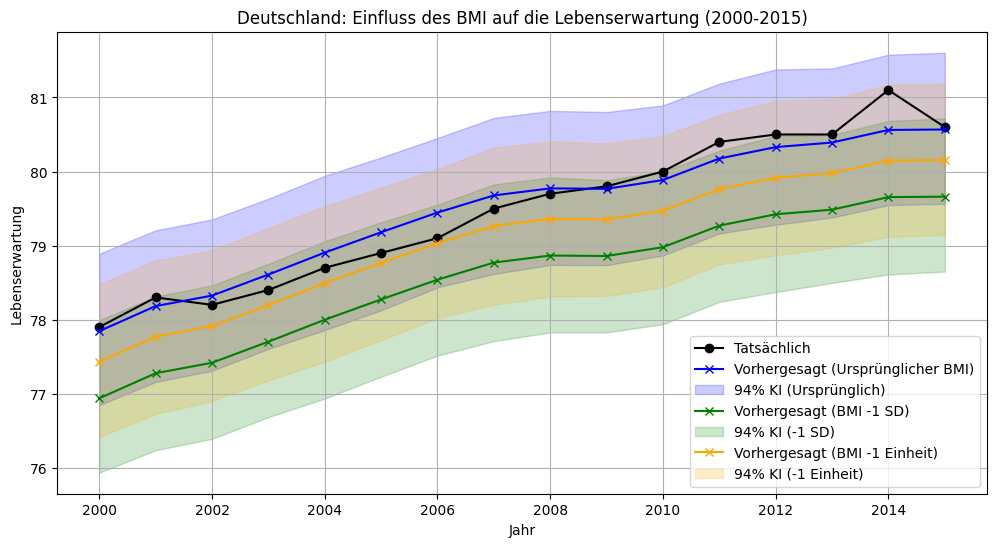


Germany BMI Simulation Results (2000-2015):

Year: 2015
Actual Life Expectancy: 80.60
Predicted (Original BMI): 80.57 (94% CI: [79.56, 81.60])
Predicted (BMI -1 SD): 79.66 (94% CI: [78.65, 80.72])
Predicted (BMI -1 Unit): 80.15 (94% CI: [79.15, 81.18])

Year: 2014
Actual Life Expectancy: 81.10
Predicted (Original BMI): 80.56 (94% CI: [79.55, 81.58])
Predicted (BMI -1 SD): 79.65 (94% CI: [78.61, 80.68])
Predicted (BMI -1 Unit): 80.15 (94% CI: [79.12, 81.17])

Year: 2013
Actual Life Expectancy: 80.50
Predicted (Original BMI): 80.39 (94% CI: [79.38, 81.39])
Predicted (BMI -1 SD): 79.48 (94% CI: [78.50, 80.49])
Predicted (BMI -1 Unit): 79.98 (94% CI: [78.97, 80.98])

Year: 2012
Actual Life Expectancy: 80.50
Predicted (Original BMI): 80.33 (94% CI: [79.28, 81.38])
Predicted (BMI -1 SD): 79.42 (94% CI: [78.37, 80.48])
Predicted (BMI -1 Unit): 79.92 (94% CI: [78.87, 80.95])

Year: 2011
Actual Life Expectancy: 80.40
Predicted (Original BMI): 80.18 (94% CI: [79.16, 81.19])
Predicted (BMI -1 SD

In [ ]:
bmi_idx = feature_names.index("BMI")
bmi_beta = summary.loc["BMI", "mean"]
bmi_beta_sd = summary.loc["BMI", "sd"]

bmi_original = germany_data["BMI"].values
bmi_scaled = X_scaled[germany_indices, bmi_idx]

bmi_scaled_minus_1sd = bmi_scaled - 1.0
bmi_original_minus_1 = bmi_original - 1.0
bmi_scaled_minus_1unit = scaler.transform(germany_data[feature_names].copy())
bmi_scaled_minus_1unit[:, bmi_idx] = (bmi_original_minus_1 - scaler.mean_[bmi_idx]) / scaler.scale_[bmi_idx]
bmi_scaled_minus_1unit = bmi_scaled_minus_1unit[:, bmi_idx]

delta_bmi_1sd = bmi_scaled_minus_1sd - bmi_scaled
germany_pred_mean_bmi_1sd = germany_pred_mean + delta_bmi_1sd * bmi_beta
germany_pred_samples_bmi_1sd = germany_pred_samples + delta_bmi_1sd[None, :] * np.random.normal(bmi_beta, bmi_beta_sd, size=(germany_pred_samples.shape[0], 1))
germany_pred_lower_bmi_1sd = np.percentile(germany_pred_samples_bmi_1sd, 3, axis=0)
germany_pred_upper_bmi_1sd = np.percentile(germany_pred_samples_bmi_1sd, 97, axis=0)

delta_bmi_1unit = bmi_scaled_minus_1unit - bmi_scaled
germany_pred_mean_bmi_1unit = germany_pred_mean + delta_bmi_1unit * bmi_beta
germany_pred_samples_bmi_1unit = germany_pred_samples + delta_bmi_1unit[None, :] * np.random.normal(bmi_beta, bmi_beta_sd, size=(germany_pred_samples.shape[0], 1))
germany_pred_lower_bmi_1unit = np.percentile(germany_pred_samples_bmi_1unit, 3, axis=0)
germany_pred_upper_bmi_1unit = np.percentile(germany_pred_samples_bmi_1unit, 97, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(germany_years, germany_actual, 'o-', label="Tatsächlich", color='black')
plt.plot(germany_years, germany_pred_mean, 'x-', label="Vorhergesagt (Ursprünglicher BMI)", color='blue')
plt.fill_between(germany_years, germany_pred_lower, germany_pred_upper, alpha=0.2, color='blue', label="94% KI (Ursprünglich)")
plt.plot(germany_years, germany_pred_mean_bmi_1sd, 'x-', label="Vorhergesagt (BMI -1 SD)", color='green')
plt.fill_between(germany_years, germany_pred_lower_bmi_1sd, germany_pred_upper_bmi_1sd, alpha=0.2, color='green', label="94% KI (-1 SD)")
plt.plot(germany_years, germany_pred_mean_bmi_1unit, 'x-', label="Vorhergesagt (BMI -1 Einheit)", color='orange')
plt.fill_between(germany_years, germany_pred_lower_bmi_1unit, germany_pred_upper_bmi_1unit, alpha=0.2, color='orange', label="94% KI (-1 Einheit)")
plt.xlabel("Jahr")
plt.ylabel("Lebenserwartung")
plt.title("Deutschland: Einfluss des BMI auf die Lebenserwartung (2000-2015)")
plt.legend()
plt.grid(True)
plt.savefig('germany_bmi_simulation.png')
plt.show()

print("\nGermany BMI Simulation Results (2000-2015):")
for year, actual, orig_mean, orig_lower, orig_upper, mean_1sd, lower_1sd, upper_1sd, mean_1unit, lower_1unit, upper_1unit in zip(
    germany_years, germany_actual, germany_pred_mean, germany_pred_lower, germany_pred_upper,
    germany_pred_mean_bmi_1sd, germany_pred_lower_bmi_1sd, germany_pred_upper_bmi_1sd,
    germany_pred_mean_bmi_1unit, germany_pred_lower_bmi_1unit, germany_pred_upper_bmi_1unit
):
    print(f"\nYear: {year}")
    print(f"Actual Life Expectancy: {actual:.2f}")
    print(f"Predicted (Original BMI): {orig_mean:.2f} (94% CI: [{orig_lower:.2f}, {orig_upper:.2f}])")
    print(f"Predicted (BMI -1 SD): {mean_1sd:.2f} (94% CI: [{lower_1sd:.2f}, {upper_1sd:.2f}])")
    print(f"Predicted (BMI -1 Unit): {mean_1unit:.2f} (94% CI: [{lower_1unit:.2f}, {upper_1unit:.2f}])")

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("/content/sample_data/who_dataset_fixed.csv")

feature_names = ["GDP_per_capita", "Alcohol_consumption", "BMI", "Schooling"]
target = 'Life_expectancy'

X = df[feature_names].copy()
y = df[target].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_centered = y - y.mean()


In [ ]:
with pm.Model() as linear_model_named:
    X_data = pm.MutableData("X", X_scaled)
    y_data = pm.MutableData("y", y_centered)

    alpha = pm.Normal("alpha", mu=0, sigma=10)

    betas = []
    for name in feature_names:
        beta = pm.Normal(name, mu=0, sigma=1)
        betas.append(beta)

    beta_stack = pm.math.stack(betas)
    mu = alpha + pm.math.dot(X_data, beta_stack)
    sigma = pm.HalfNormal("sigma", sigma=10)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data)

    trace_named = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)


/usr/local/lib/python3.11/dist-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

In [ ]:
with pm.Model() as linear_model:

    alpha = pm.Normal("alpha", mu=0, sigma=10)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=X.shape[1])
    sigma = pm.HalfNormal("sigma", sigma=10)

    mu = alpha + pm.math.dot(X_scaled, betas)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_centered)
    trace = pm.sample(2000, tune=1000, target_accept=0.80, return_inferencedata=True)

Output()

In [ ]:
az.summary(trace_named, round_to=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Alcohol_consumption,-0.6909,0.1379,-0.9343,-0.4170,0.0025,0.0021,3032.6201,2640.7264,1.0004
BMI,2.1223,0.1420,1.8573,2.3873,0.0027,0.0020,2814.8344,2845.4750,1.0004
GDP_per_capita,2.4356,0.1302,2.1792,2.6724,0.0024,0.0019,2965.1347,2885.9948,1.0004
Schooling,4.4959,0.1869,4.1427,4.8448,0.0038,0.0030,2375.1592,2249.3147,1.0026
alpha,-0.0015,0.1085,-0.2046,0.2099,0.0017,0.0017,4128.7153,2865.8753,1.0005
sigma,5.8699,0.0790,5.7240,6.0177,0.0013,0.0012,3570.2656,2810.8239,1.0009


In [ ]:
az.summary(trace, round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.0041,0.1121,-0.2034,0.2114,0.0017,0.0020,4253.8323,2720.7956,1.0004
betas[0],2.4369,0.1338,2.1937,2.6958,0.0022,0.0021,3844.2463,3150.8807,1.0015
betas[1],-0.6927,0.1393,-0.9476,-0.4309,0.0023,0.0019,3615.0289,3044.3149,1.0014
betas[2],2.1246,0.1420,1.8697,2.3962,0.0026,0.0023,3024.8703,2532.8778,0.9999
betas[3],4.4962,0.1809,4.1634,4.8301,0.0036,0.0026,2573.9853,2699.0235,1.0001
sigma,5.8710,0.0758,5.7313,6.0126,0.0012,0.0012,3669.0078,2897.6703,1.0036


In [ ]:
# MultiTrace objesi ise
type(trace)

# InferenceData objesi
type(trace_named)

# trace_named'in gruplarını gör
trace_named.groups()
# >> ['posterior', 'sample_stats', 'observed_data', 'prior', vs.]


['posterior', 'sample_stats', 'observed_data', 'constant_data']

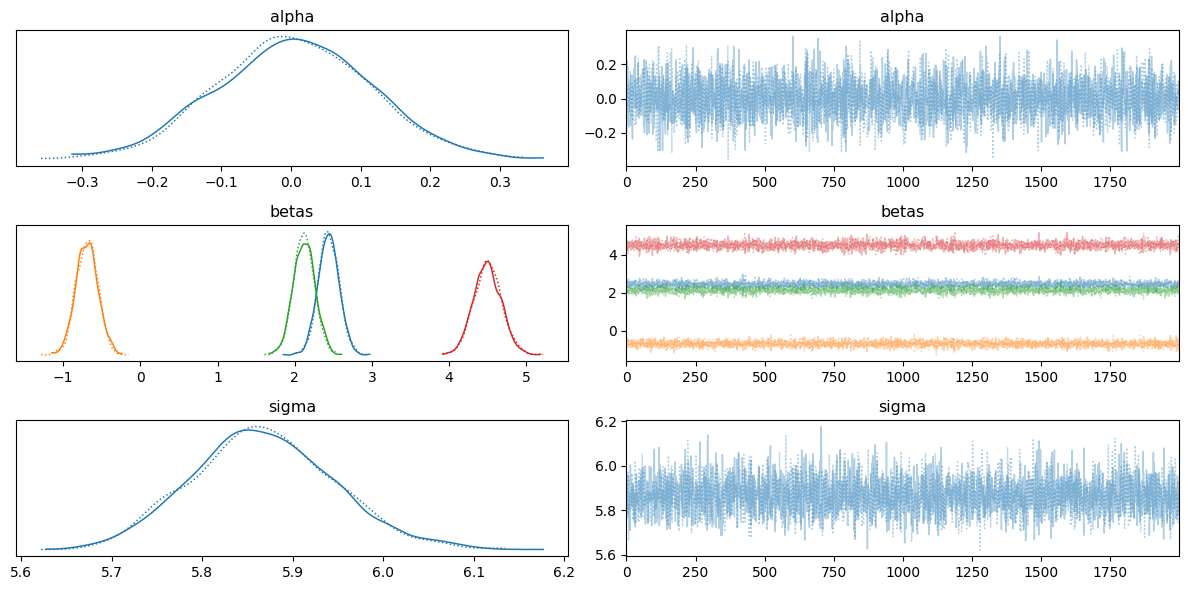

In [ ]:
az.plot_trace(trace, var_names=["alpha","betas","sigma"])
plt.tight_layout()
plt.show()


Output()

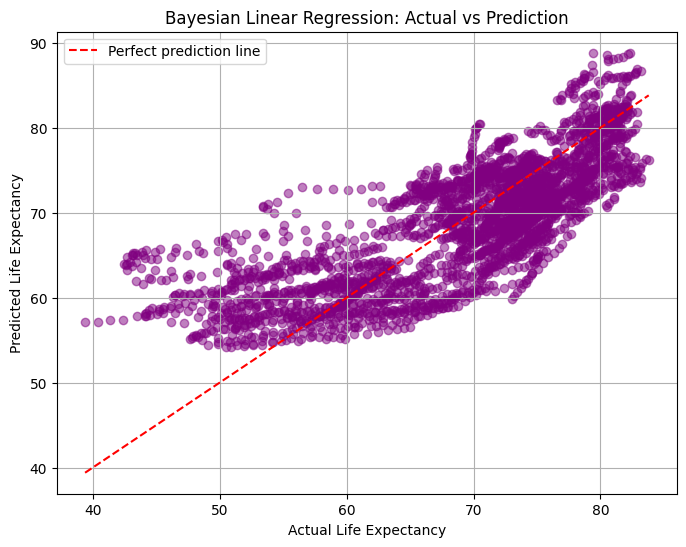

In [ ]:
with linear_model_named:
    posterior_pred = pm.sample_posterior_predictive(trace_named, var_names=["y_obs"])

y_mean = y.mean()
# Tahmin örneklerini al
y_pred_samples = posterior_pred.posterior_predictive["y_obs"].values + y.mean()
# Eğer 3 boyutlu ise (chain, draw, sample)
if y_pred_samples.ndim == 3:
    y_pred_samples = y_pred_samples.reshape(-1, y_pred_samples.shape[-1])  # (n_samples, n_observations)

# Ortalama tahminleri hesapla
y_pred_mean = y_pred_samples.mean(axis=0)

# Gerçek vs tahmin grafiği
plt.figure(figsize=(8,6))
plt.scatter(y, y_pred_mean, alpha=0.5, color='purple')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfect prediction line")
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Bayesian Linear Regression: Actual vs Prediction")
plt.legend()
plt.grid(True)
plt.show()

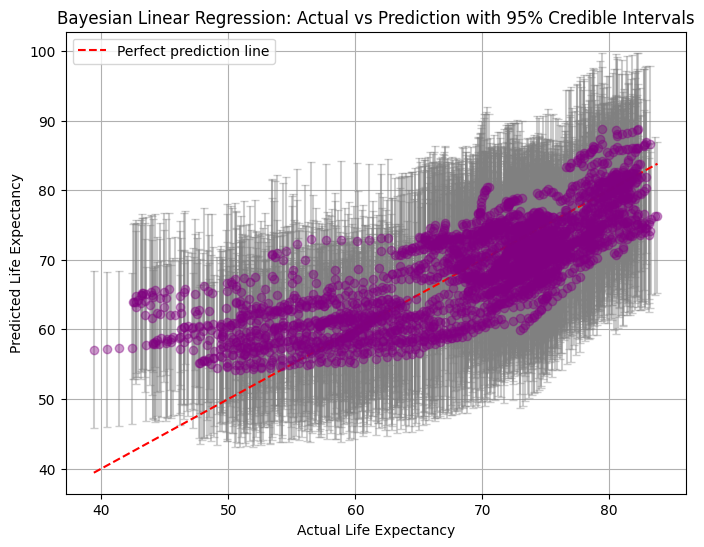

In [ ]:
# 94% credibility interval hesapla (quantiles)
lower_bound = np.percentile(y_pred_samples, 3, axis=0)
upper_bound = np.percentile(y_pred_samples, 97, axis=0)
plt.figure(figsize=(8,6))
plt.errorbar(y, y_pred_mean,
             yerr=[y_pred_mean - lower_bound, upper_bound - y_pred_mean],
             fmt='o', alpha=0.4, color='purple', ecolor='gray', capsize=3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfect prediction line")
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Bayesian Linear Regression: Actual vs Prediction with 95% Credible Intervals")
plt.legend()
plt.grid(True)
plt.show()


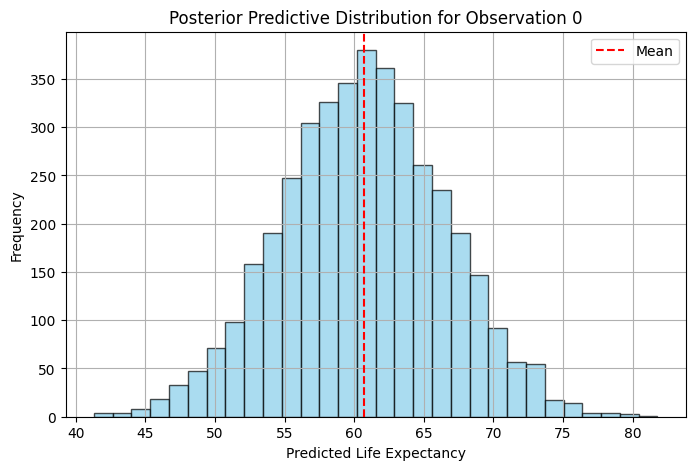

In [ ]:
sample_index = 0  # İlk veri noktası
samples_for_one = y_pred_samples[:, sample_index]

plt.figure(figsize=(8,5))
plt.hist(samples_for_one, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(np.mean(samples_for_one), color='red', linestyle='--', label='Mean')
plt.title(f"Posterior Predictive Distribution for Observation {sample_index}")
plt.xlabel("Predicted Life Expectancy")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-11-ef3107f13f70>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_violin_long, x="Observation", y="Predicted Life Expectancy", inner="quartile", palette="muted")


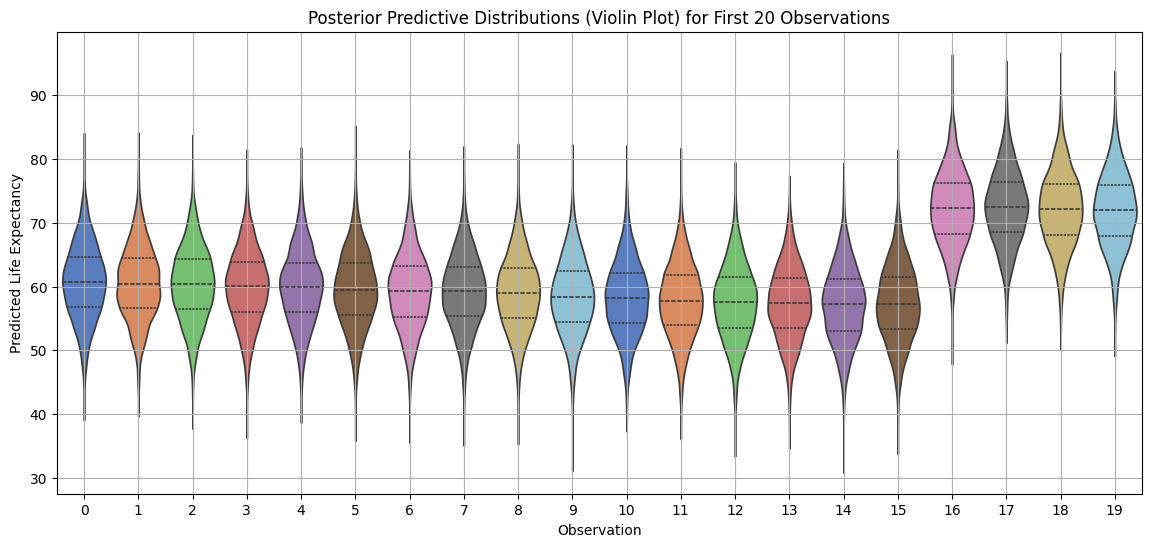

In [ ]:
import seaborn as sns
import pandas as pd

# İlk 20 gözlem için
n_samples_show = 20
subset_samples = y_pred_samples[:, :n_samples_show]

# Violin plot için veriyi long formata çevir
df_violin = pd.DataFrame(subset_samples)
df_violin_long = df_violin.melt(var_name="Observation", value_name="Predicted Life Expectancy")

plt.figure(figsize=(14,6))
sns.violinplot(data=df_violin_long, x="Observation", y="Predicted Life Expectancy", inner="quartile", palette="muted")
plt.title("Posterior Predictive Distributions (Violin Plot) for First 20 Observations")
plt.grid(True)
plt.show()


In [ ]:

print("Gerçek gözlem sayısı:", y.shape[0])
print("Tahmin edilen gözlem sayısı:", y_pred_mean.shape[0])


Gerçek gözlem sayısı: 2864
Tahmin edilen gözlem sayısı: 2864


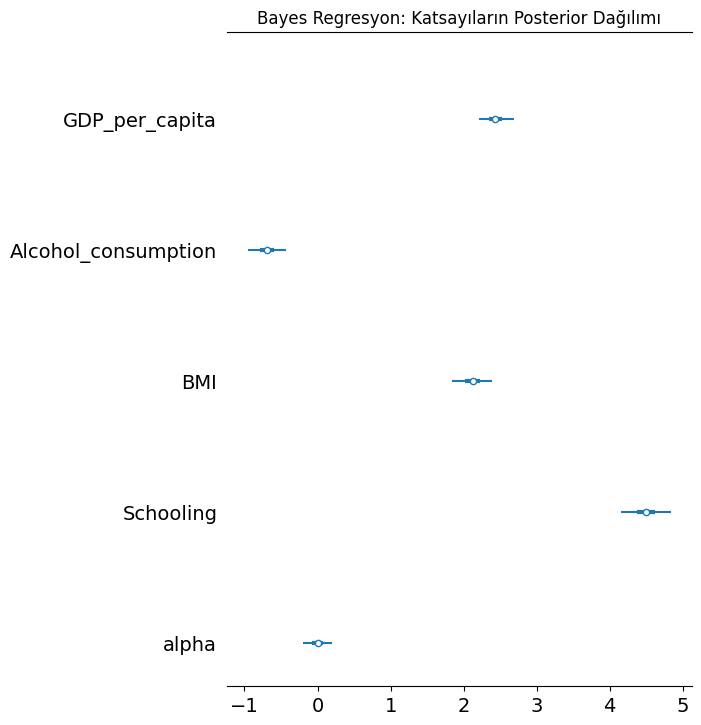

In [ ]:
az.plot_forest(trace_named,
               var_names=feature_names + ["alpha"],
               combined=True)
plt.title("Bayes Regresyon: Katsayıların Posterior Dağılımı")
plt.show()



array([<Axes: title={'center': 'betas\n0'}>,
       <Axes: title={'center': 'betas\n2'}>], dtype=object)

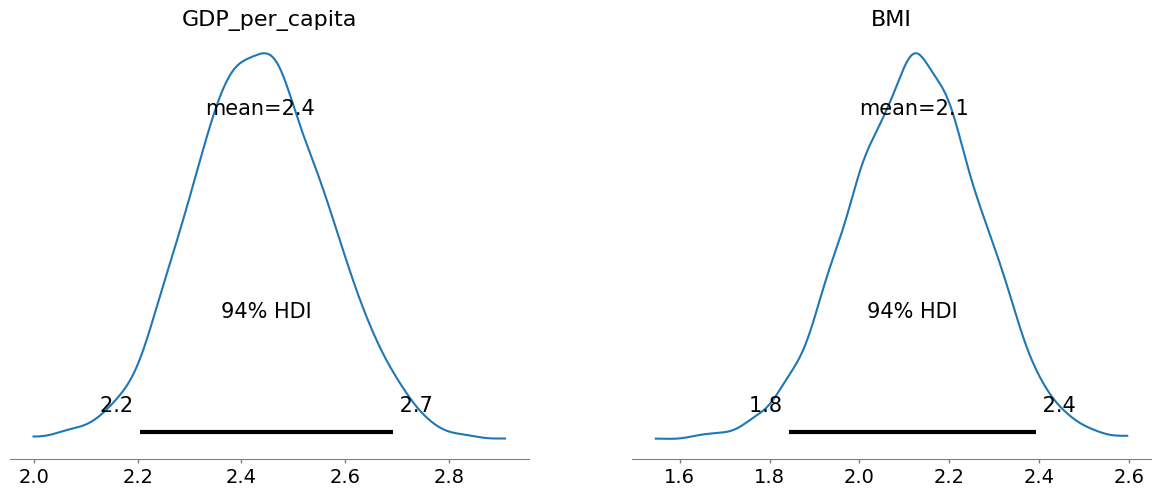

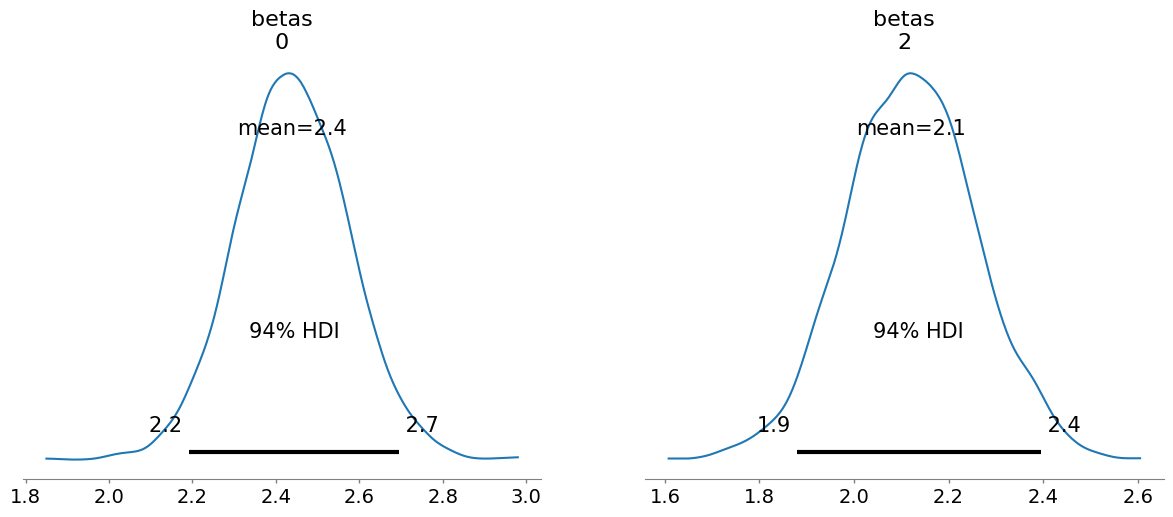

In [ ]:
az.plot_posterior(trace_named, var_names=["GDP_per_capita", "BMI"])
az.plot_posterior(trace, var_names=["betas"], coords={"betas_dim_0": [0, 2]})


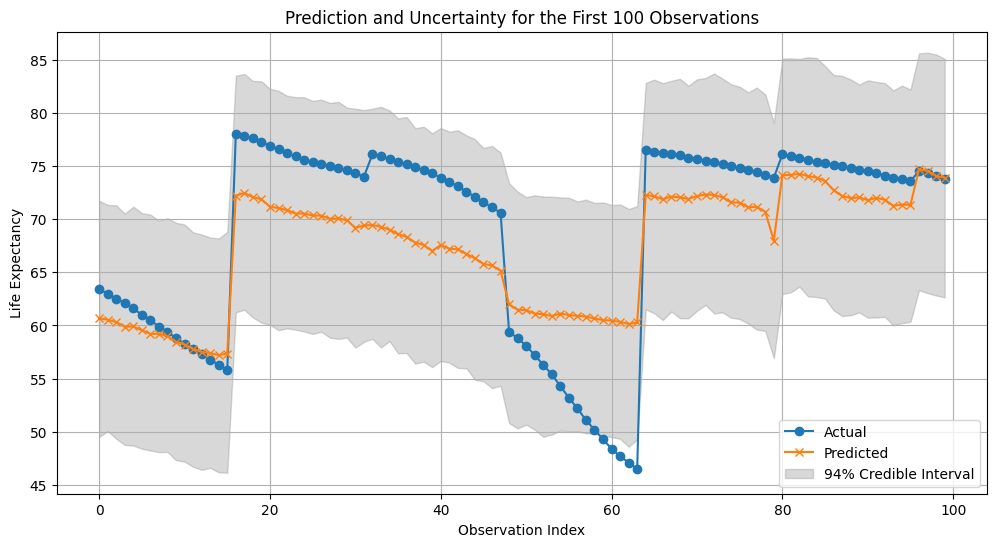

In [ ]:
lower = np.percentile(y_pred_samples, 3, axis=0)
upper = np.percentile(y_pred_samples, 97, axis=0)

plt.figure(figsize=(12,6))
plt.plot(y[:100], label="Actual", marker="o")
plt.plot(y_pred_mean[:100], label="Predicted", marker="x")
plt.fill_between(np.arange(100), lower[:100], upper[:100], alpha=0.3, color="gray", label="94% Credible Interval")
plt.title("Prediction and Uncertainty for the First 100 Observations")
plt.ylabel("Life Expectancy")
plt.xlabel("Observation Index")
plt.legend()
plt.grid(True)
plt.show()


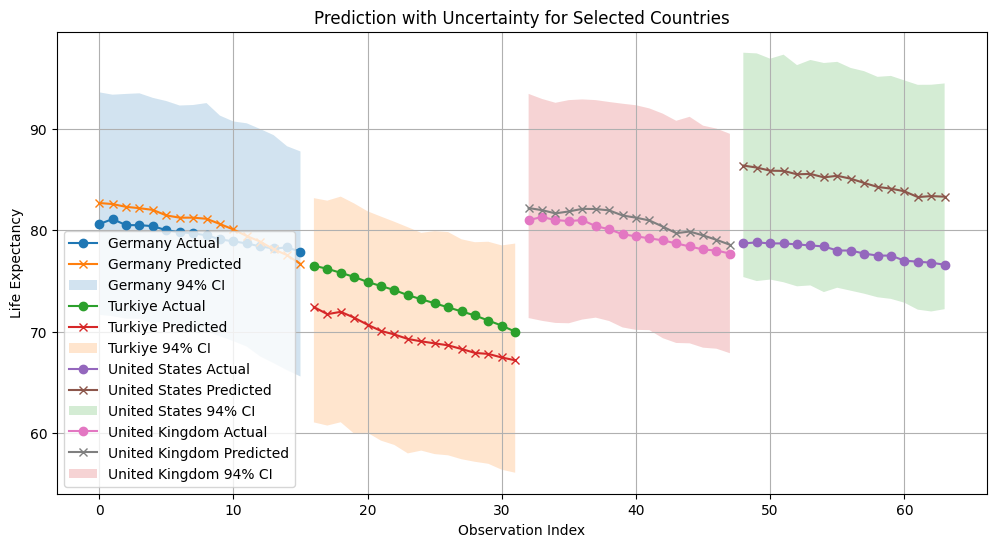

In [ ]:
# Ülkeleri filtrele, ama orijinal indeksleri koru
countries_of_interest = ["Germany", "Turkiye", "United States", "United Kingdom"]
df_filtered = df[df["Country"].isin(countries_of_interest)].copy()  # reset_index kullanmıyoruz

# Gerekli veriler
y_filtered = df_filtered["Life_expectancy"].values
# Orijinal indeksleri kullanarak tahminleri al
original_indices = df_filtered.index  # df_filtered'ın orijinal df içindeki indeksleri
y_pred_mean_filtered = y_pred_mean[original_indices]
lower_filtered = lower[original_indices]
upper_filtered = upper[original_indices]
countries = df_filtered["Country"].values

# Grafik çizimi
plt.figure(figsize=(12,6))

for i, country in enumerate(countries_of_interest):
    indices = np.where(countries == country)[0]
    plt.plot(indices, y_filtered[indices], 'o-', label=f"{country} Actual")
    plt.plot(indices, y_pred_mean_filtered[indices], 'x-', label=f"{country} Predicted")
    plt.fill_between(indices, lower_filtered[indices], upper_filtered[indices], alpha=0.2, label=f"{country} 94% CI")

plt.title("Prediction with Uncertainty for Selected Countries")
plt.xlabel("Observation Index")
plt.ylabel("Life Expectancy")
plt.legend()
plt.grid(True)
plt.show()
